# Reproducible code
For maximal reproducibility, we recommend to run the "Create_VirtualEnv....ipynb", using the default shell of your OS or bash. You are then required to change the current notebook's kernel to "RadTMSR_env", which stores all required versions of the used modules.

**Written in Python 4.20.11 and Jupyter Lab 4.0.7**


In [1]:
input("Reassure that Kernel is set to RadTMSR_env before continuing")

Reassure that Kernel is set to RadTMSR_env before continuing 


''

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import networkx as nx
from scipy.stats import binom_test
from collections import Counter
#import requests

In [3]:
## create folder for storing output
if not os.path.exists("RTMR_Output"):
    os.makedirs("RTMR_Output")
if not os.path.exists("RTMR_Output/Keywords"):
    os.makedirs("RTMR_Output/Keywords")

#### **To run this script successfully, R has to be installed and Rscript.exe has to be in the local environment's PATH.**

To ensure that Rscript.exe is in the PATH, follow the following steps:

1. Run the cell below. If Rscript.exe is found, you are informed that R scripts can be run successfully. Otherwise, you are required to input the absolute directory of the Rscript.exe. To this end, follow the following guidance:

2. Locate the Rscript.exe file, usually in the bin folder of your R installation directory. The path might look something like C:\Program Files\R\R-x.x.x\bin.

In [4]:
try:
    result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
    print("Rscript version:", result.stdout)
    print("R scripts can be successfully run.")
    
except FileNotFoundError:
    rscript_path = input("Rscript.exe not found. Please enter the absolute directory path where Rscript.exe is located: ")
    #rscript_path = r"C:/Program Files/R/R-4.3.2/bin"
    print("Absolute path provided: ", rscript_path)
    
    # Add the path to the PATH environment variable for the current session
    os.environ['PATH'] += os.pathsep + rscript_path
    
    # Verify if Rscript is accessible this time
    try:
        result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
        print("Rscript version:", result.stdout)
        print("R scripts can be successfully run.")
    except FileNotFoundError:
        raise Exception("Rscript not found. Please check the path.")

Rscript version: Rscript (R) version 4.3.2 (2023-10-31)

R scripts can be successfully run.


In [5]:
# Import data
dfTot = pd.read_excel("asreview_dataset_relevant_Radicalization.xlsx")
#dfTot.head()

# Data Overview

In [6]:
print('Number of articles (unprocessed): {}'.format(len(dfTot)))

Number of articles (unprocessed): 4019


### Publication metrics

In [7]:
dfTot["Title"] = dfTot["Title"].apply(lambda x: str(x).lower())

In [8]:
dfTot['Publication Type'].value_counts()

Publication Type
J    3742
C     233
S      28
B      16
Name: count, dtype: int64

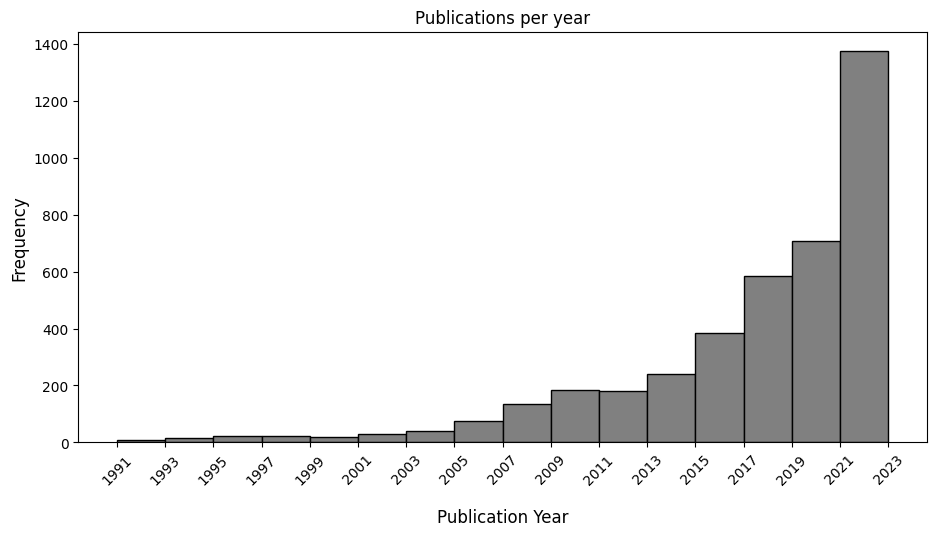

In [9]:
# Determine the range of years
min_year = dfTot['Publication Year'].min()
max_year = dfTot['Publication Year'].max()

# Set the bin size to 2 years for detailed x-axis labels
bins = range(min_year, max_year + 2, 2)  # Adding 2 to include the last year in the range

# Plot the histogram
plt.figure(figsize=(10, 6))
dfTot['Publication Year'].hist(bins=bins, edgecolor='black', color='gray')

# Customize the x-axis labels for better detail
plt.xticks(bins, rotation=45)  # Rotate labels to 45 degrees
plt.xlabel('Publication Year', fontsize=12, labelpad=15)  # Add padding to x-axis label
plt.ylabel('Frequency', fontsize=12)
plt.title("Publications per year")

# Remove the background grid
plt.grid(False)

# Adjust layout to make room for the caption
plt.tight_layout(pad=3)

#Save plot
plt.savefig('RTMR_Output/publicationsperyear_hist.png', bbox_inches='tight', dpi=600)


# Show the plot
plt.show()


In [10]:
print("Number of Journals: ", len(dfTot['Journal ISO Abbreviation'].unique()))

Number of Journals:  1114


* #### Research fields / Journal categories 

Research Areas

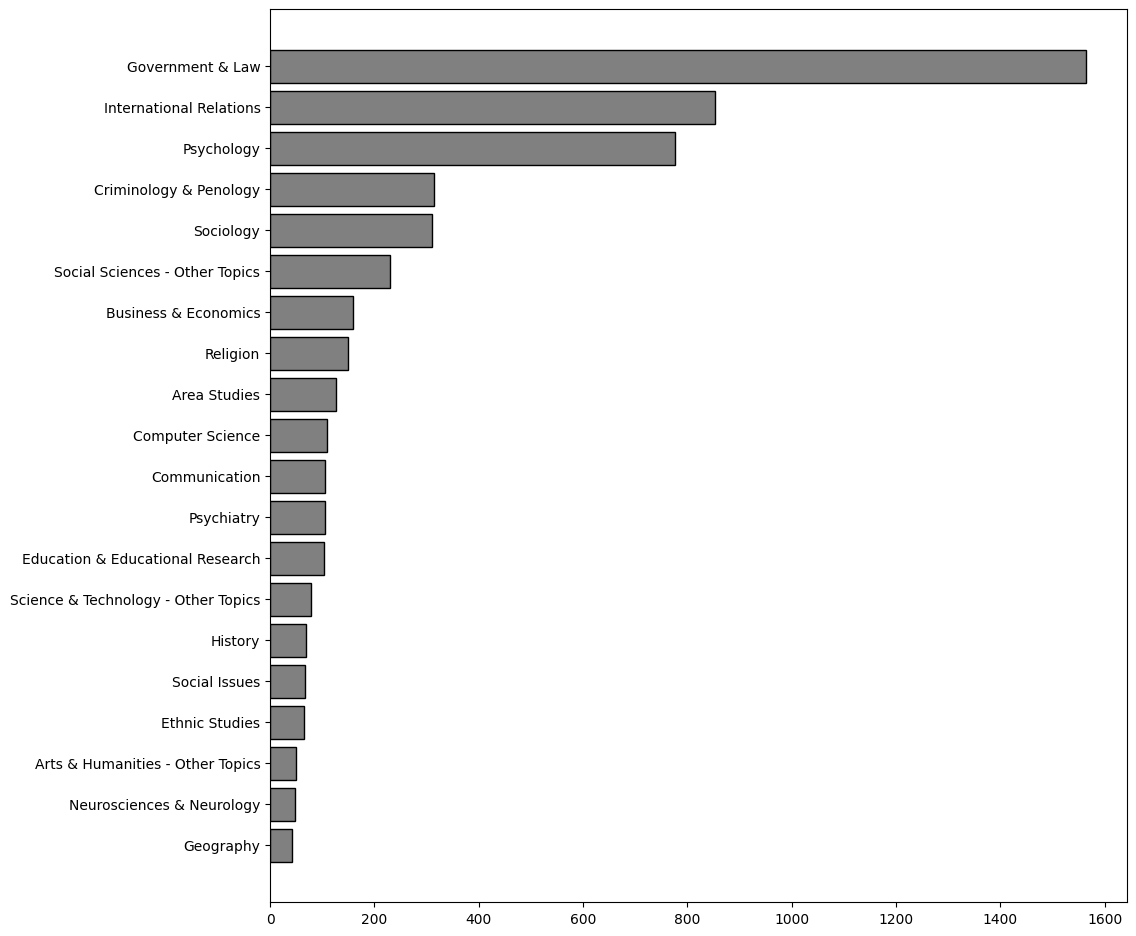

In [11]:
res_areas_freq = dfTot['Research Areas'].str.split(';').explode().str.strip().value_counts()
res_areas_freq.to_excel('RTMR_Output/Research_Areas_freq.xlsx')

# Plot
plt.figure(figsize=(12, 10))
plt.barh(res_areas_freq.iloc[0:20].index[::-1], res_areas_freq.iloc[0:20][::-1], edgecolor='black', color='gray')

# Customize the y-axis labels for better detail
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
#plt.xlabel('Frequency', fontsize=12, labelpad=15)
#plt.ylabel('Research Field', fontsize=12, labelpad=15)
#plt.title("Top 20 Most Frequent Research Fields", fontsize=14)

# Adjust layout to make room for the caption
plt.tight_layout(pad=3)

# Save plot
plt.savefig('RTMR_Output/Research_Areas_freq_barplot.png', bbox_inches='tight', dpi=600)

# Show the plot
plt.show()


WoS Categories

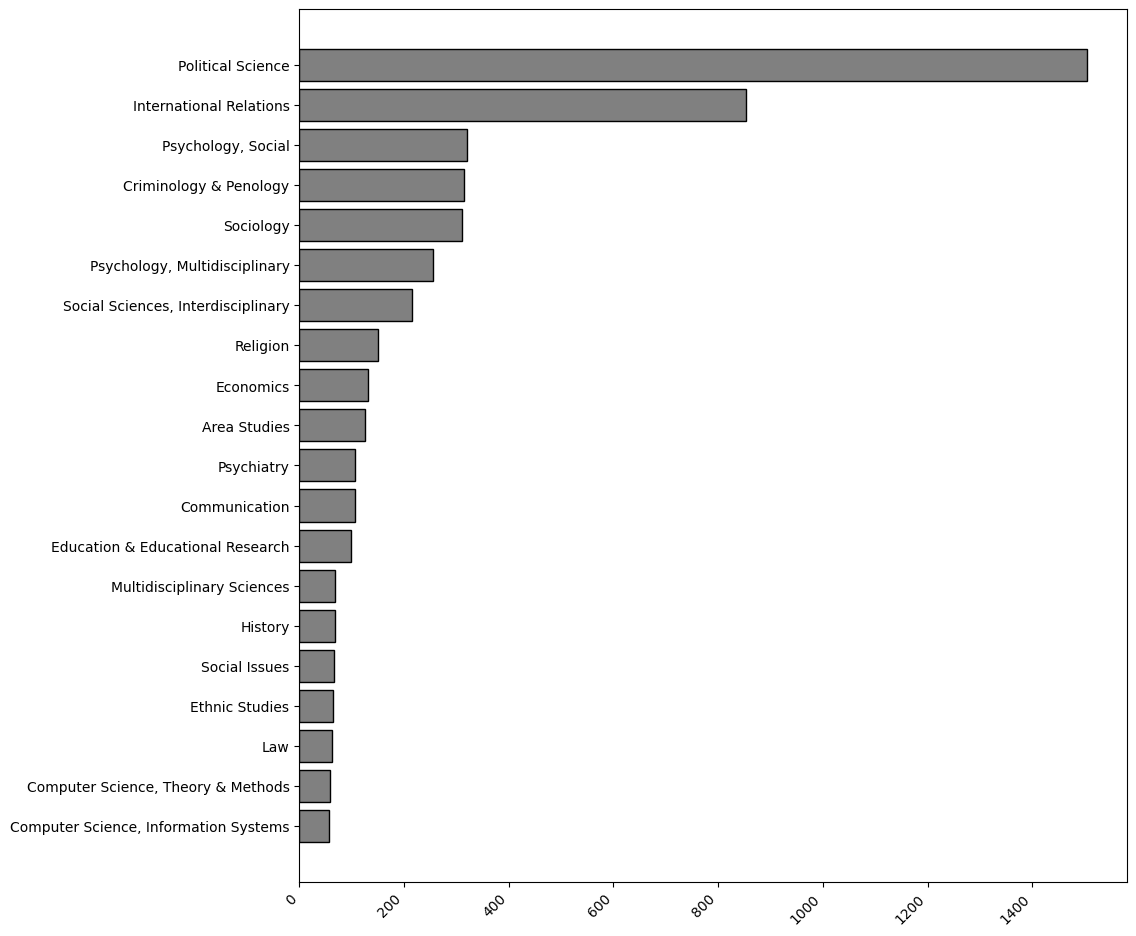

In [12]:
wos_cat_freq = dfTot['WoS Categories'].str.split(';').explode().str.strip().value_counts()
wos_cat_freq.to_excel('RTMR_Output/WoS_Categories_freq.xlsx')

# Plot
#plt.figure(figsize=(10, 6))
#dfTot['Publication Year'].hist(bins=bins, edgecolor='black', color='gray')
#plt.bar(wos_cat_freq.iloc[0:9].index, wos_cat_freq.iloc[0:9], edgecolor='black', color='gray')

plt.figure(figsize=(12, 10))
plt.barh(wos_cat_freq.iloc[0:20].index[::-1], wos_cat_freq.iloc[0:20][::-1], edgecolor='black', color='gray')



# Customize the x-axis labels for better detail
plt.xticks(rotation=45, ha = "right")  # Rotate labels to 45 degrees
#plt.xlabel('Research Field', fontsize=12, labelpad=15)  # Add padding to x-axis label
#plt.ylabel('Frequency', fontsize=12, labelpad=15)
#plt.title("Top 10 Most Frequent Web of Science Categories", fontsize=14)

# Adjust layout to make room for the caption
plt.tight_layout(pad=3)

#Save plot
plt.savefig('RTMR_Output/WoS_Categories_freq_barplot.png', bbox_inches='tight', dpi=600)

# Show the plot
plt.show()

# Study 1 - Keywords Analysis

# Preprocessing

**Pipeline**:

`data` --> `cleaning` --> `exclusion filter (stopwords, countries, exclusion terms)` --> `classification and replacement` --> `clean_data` --> `nounbydoc` --> *transfer to R* --> `negative binomial` --> `topic modelling` --> `frequence analysis` --> `co-occurrence analysis` --> *transfer to Python* --> `co-occurrence network map`

In [13]:
data = dfTot[["record_id","Author Keywords"]].copy()
data.rename(columns={'Author Keywords': 'keywords'}, inplace=True)

In [14]:
data = data.dropna(subset = ['keywords'])

In [15]:
len(data)

3093

### 1. Cleaning

In [16]:
# Exclude NaNs
data = data.dropna(subset = ['keywords'])

# lower case, replace "-" with space, and split keywords
data.keywords = data.keywords.apply(lambda x: x.replace("-"," ").split("; "))
data.keywords = data.keywords.apply(lambda x: [str(item).lower() for item in x])
#data

In [17]:
print(f"Total number of keywords: {len(data.keywords.sum())}")
print(f"Number of unique keywords: {len(set(data.keywords.sum()))}")


Total number of keywords: 16751
Number of unique keywords: 6608


-------------------------------------------------------------------------------------------

### *Frequency of countries and regions*
(Has to be done before term exclusion)

In [18]:
from country_list import countries_for_language
countries_dict = dict(countries_for_language('en'))
countries_raw = list(countries_dict.values())
countries = [term.lower() for term in countries_raw]

region_list = ['africa','asia','europe','america','middle east',
               "western europe", "northern ireland", "hong kong", "basque country",
               "eastern europe", "southeast asia", "south asia", "somali", "britain", "latin america", "central asia",
               "palestine", 'middle east and north africa']

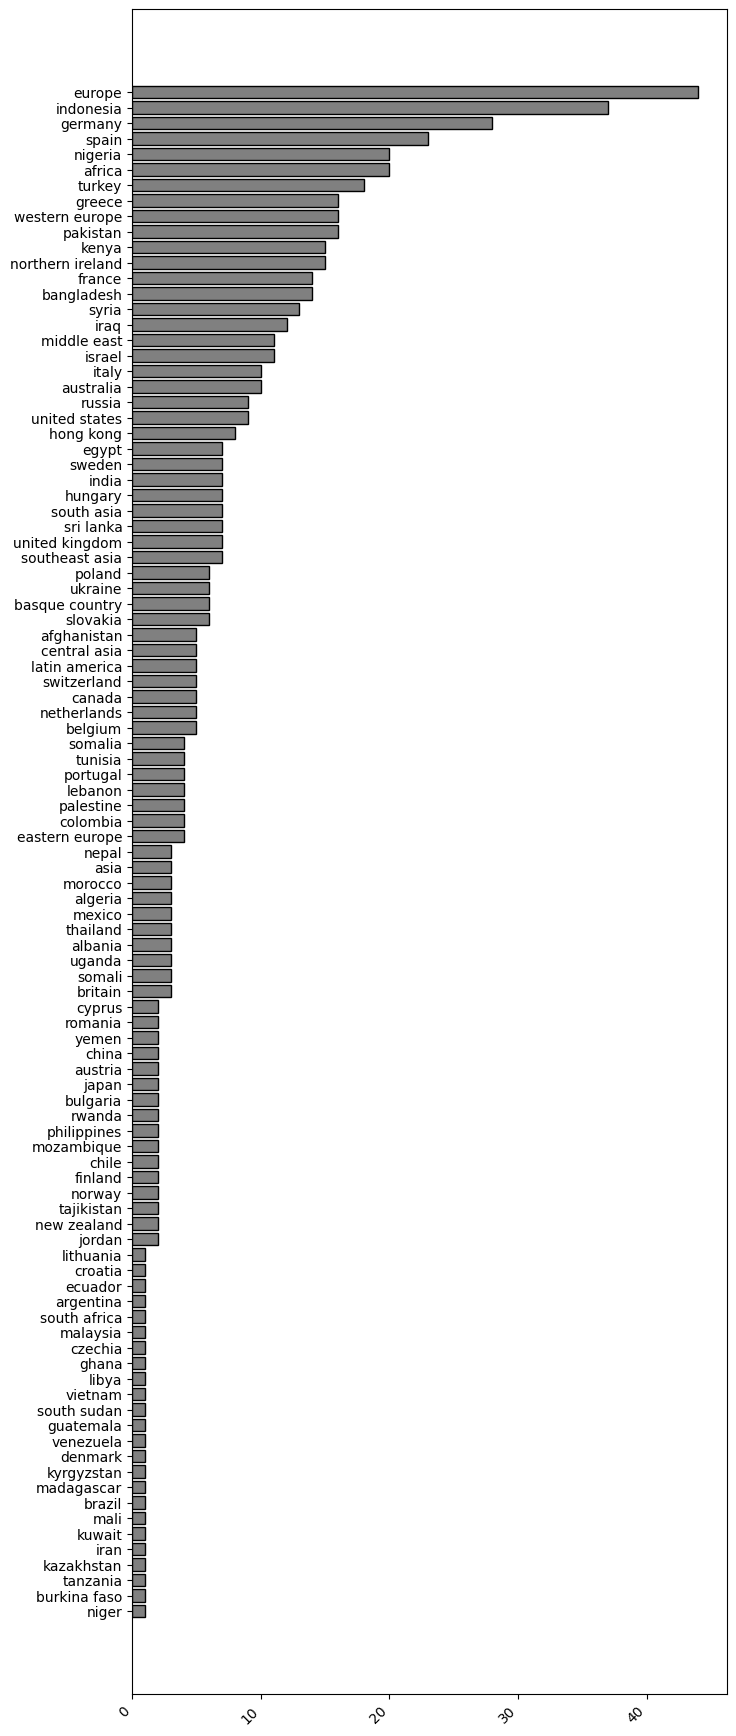

In [19]:
freq_regions = {key: value for key, value in Counter(data.keywords.apply(lambda x: list(set(x))).sum()).items() if key in countries + region_list}
freq_regions = pd.Series(dict(sorted(freq_regions.items(), key=lambda item: item[1])))

freq_regions.to_excel('RTMR_Output/Keywords/Keywords_Regions_freq.xlsx')

# Plot
plt.figure(figsize=(8, 18))
#dfTot['Publication Year'].hist(bins=bins, edgecolor='black', color='gray')
plt.barh(freq_regions.index, freq_regions, edgecolor='black', color='gray')

# Customize the x-axis labels for better detail
plt.xticks(rotation=45, ha = "right")  # Rotate labels to 45 degrees
#plt.xlabel('Research Field', fontsize=12, labelpad=15)  # Add padding to x-axis label
#plt.title("Frequency of Countries and Regions (Keywords)", fontsize=14)

# Adjust layout to make room for the caption
plt.tight_layout(pad=3)

#Save plot
plt.savefig('RTMR_Output/Keywords/Keywords_Regions_freq_barplot.png', bbox_inches='tight', dpi=600)

# Show the plot
plt.show()

-----------------------------------------------------------------------------------------------------

### 2. Exclusion filter (stopwords, countries, and exclusion terms)

In [20]:
from stop_words import get_stop_words
stoplist = get_stop_words('en')

In [21]:
exclusion_list = pd.read_excel("Exclusion_def.xlsx")
excl_list = list(exclusion_list.Exclusion)
excl_list = [str(item) for item in excl_list]
region_list = ['africa','asia','europe','america','middle east',
               "western europe", "northern ireland", "hong kong", "basque country",
               "eastern europe", "southeast asia", "south asia", "somali", "britain", "latin america", "central asia",
               "palestine", 'middle east and north africa']

In [22]:
exclusion_filter = set(excl_list + countries + stoplist + region_list)

*Apply exclusion filter*

In [23]:
data.keywords = data.keywords.apply(lambda x: [item for item in x if item not in exclusion_filter])
#data                                   

In [24]:
print(f"Total number of keywords after exclusion: {len(data.keywords.sum())}")
print(f"Number of unique keywords after exclusion: {len(set(data.keywords.sum()))}")

Total number of keywords after exclusion: 14702
Number of unique keywords after exclusion: 5728


### 3. Term Classification and Replacement (TMSR dictionary.py)

In [25]:
from TMSR_dictionary import word_dict
from Word_functions.word_functions_py import classification, extend_keywords, to_nounbydoc

In [26]:
#keywords_list = sum(data.keywords, [])

In [27]:
#count_dict, uniques, terms_in_cat_dict = classification(keywords_list,word_dict)

In [28]:
#sorted(count_dict.items(), key=lambda item: item[1], reverse = True)

In [29]:
#print(f"{len(uniques)} not classified keywords, with {len(set(uniques))} unique terms.")

In [30]:
#frequency = Counter(uniques)
#print(frequency)

In [ ]:
clean_data = data.copy(deep = True)
clean_data["cat_keywords"] = clean_data.keywords.apply(lambda x: extend_keywords(x,word_dict))
clean_data

In [ ]:
clean_data.to_json("RTMR_Output/Keywords/Keywords_clean_data.json", index = False)

In [ ]:
print(f"Total number of keywords after classification: {len(clean_data.cat_keywords.sum())}")
print(f"Number of unique keywords after classification: {len(set(clean_data.cat_keywords.sum()))}")

### 4. Nounbydoc

Prepare data for van Lissa's code in R (negative binomial, topic modelling, cooccurrences)

In [ ]:
nounbydoc = to_nounbydoc(clean_data, "cat_keywords")
nounbydoc

In [ ]:
nounbydoc.to_csv(r"RTMR_Output/Keywords/Keywords_nounbydoc.csv", index = False)

In [ ]:
frequency = Counter(nounbydoc.term)
one_hit_wonders = [term for term, n in frequency.items() if n == 1]
print("Number of terms occurring only once: ", len(one_hit_wonders))

===========================================================================================================================

### Run R script for:
* Negative Binomial (Pruning)
* Word Frequency
* Topic Modelling
* Term co-occurrences

##### using van Lissa's R code
  
===========================================================================================================================

In [ ]:
os.chdir("Word_functions")
r_script_path = 'keywords_processing.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

## I. Word Frequency

In [ ]:
freq_df = pd.read_csv(r"RTMR_Output/Keywords/Keywords_freq.csv").sort_values(by= "Frequency", ascending=False).reset_index()
len(freq_df)

In [ ]:
# Define the categorization
micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "misogyny"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience", "family"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)


# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt.figure(figsize=(10, 14))

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes for categories in the foreground
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes for categories in the foreground with white filling
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

plt.xlabel('Frequency Analysis 1', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.savefig('RTMR_Output/Keywords/keywordsfull_frequency_of_words_wide.png', bbox_inches='tight', dpi=600)


In [ ]:
# Define the categorization
micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "misogyny"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience", "family"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt.figure(figsize=(6, 14))  # Adjusted figure size to make it more narrow

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes for categories in the foreground
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes for categories in the foreground with white filling
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

plt.xlabel('Frequency Analysis 1', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.savefig('RTMR_Output/Keywords/keywordsfull_frequency_of_words_narrow.png', bbox_inches='tight', dpi=600)


## II. Co-occurrences

In [ ]:
cooc_df_incl = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_inclrad.csv")
cooc_df_excl = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_worad.csv")
cooc_df_ado = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_adolescence.csv")
cooc_df_islamist = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_islamist.csv")
cooc_df_right = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_far-right.csv")
cooc_df_left = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_far-left.csv")
cooc_df_lone = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_lone-actor.csv")
cooc_df_foreignf = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_foreign-fighter.csv")
cooc_df_malesup = pd.read_csv(r"RTMR_Output/Keywords/Keywords_cooc_male-supremacist.csv")

In [ ]:
cooc_df_incl

In [ ]:
print("Edges: ", len(cooc_df_incl))
print("Nodes: ", len(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))
print("Min number of co-occurrences: ", cooc_df_incl.cooc.min())


### Network Visualisation

#### a) general network

In [ ]:
# Define terms for each category based on your categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "misogyny",
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change",
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience", "family"
]

radicalism_nodes = ["radicalism", "far right", "islamist", "far left", "foreign fighter", "lone actor", "male supremacist"]

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_incl.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Draw nodes with shape based on their category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

# Updated color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['radicalism'], node_shape='D', linewidths=2.5, alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors: grey if connected to radicalism, otherwise black
edge_colors = ['grey' if 'radicalism' in (u, v) else '#5495a4' for u, v in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_radicalism.png', bbox_inches='tight', dpi=600)


#### b) centred around "adolescence"

In [ ]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["radicalism", "far right", "islamist"]
}

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_ado.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'adolescence'
if 'adolescence' in pos and 'radicalism' in pos:
    pos['adolescence'][0] += 0.1  # Adjust x position
    pos['adolescence'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': 'red'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_adolescence.png', bbox_inches='tight', dpi=600)


#### c) centred around "islamist"

In [ ]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["radicalism", "far right", "islamist", "foreign fighter"]
}

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_islamist.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'islamist'
if 'islamist' in pos and 'radicalism' in pos:
    pos['islamist'][0] += 0.1  # Adjust x position
    pos['islamist'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': 'red'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_islamist.png', bbox_inches='tight', dpi=600)



#### d) centred around "far right"

In [ ]:
# Define terms for each category based on categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "right wing populism", "euroscepticism",
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change",
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience"
]

radicalism_nodes = ["radicalism", "far right", "islamist"]

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_right.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Manually adjust positions to prevent overlap of "far right" and "radicalism"
if "far right" in pos and "radicalism" in pos:
    pos["far right"][0] += 0.1  # Adjust x position
    pos["far right"][1] += 0.1  # Adjust y position
if "islamist" in pos:
    pos["islamist"][0] += 0.1
    pos["islamist"][1] -= 0.1

# Function to check if two positions overlap
def positions_overlap(pos1, pos2, distance=0.1):
    return np.linalg.norm(np.array(pos1) - np.array(pos2)) < distance

# Function to adjust positions to prevent overlap
def adjust_positions(positions, adjustment_distance=0.05, max_iterations=100):
    adjusted_positions = positions.copy()
    for _ in range(max_iterations):
        overlaps = False
        for node1, pos1 in adjusted_positions.items():
            for node2, pos2 in adjusted_positions.items():
                if node1 != node2 and positions_overlap(pos1, pos2, adjustment_distance):
                    overlaps = True
                    angle = np.arctan2(pos2[1] - pos1[1], pos2[0] - pos1[0])
                    adjusted_positions[node2][0] += np.cos(angle) * adjustment_distance
                    adjusted_positions[node2][1] += np.sin(angle) * adjustment_distance
        if not overlaps:
            break
    return adjusted_positions

# Adjust positions to prevent overlap
pos = adjust_positions(pos)

# Draw nodes with shape based on their category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

# Updated color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['radicalism'], node_shape='D', linewidths=2.5, alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors to a single color (e.g., grey)
edge_colors = ['grey' for _ in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with consistent font size
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_farright.png', bbox_inches='tight', dpi=600)
plt.show()


#### e) centred around "far left"

In [ ]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["radicalism", "far right", "far left"]
}

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_left.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'far left'
if 'far left' in pos and 'radicalism' in pos:
    pos['far left'][0] += 0.1  # Adjust x position
    pos['far left'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': 'red'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_farleft.png', bbox_inches='tight', dpi=600)



#### f) centred around "lone actor"

In [ ]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["radicalism", "lone actor"]
}

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_lone.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'lone actor'
if 'lone actor' in pos and 'radicalism' in pos:
    pos['lone actor'][0] += 0.1  # Adjust x position
    pos['lone actor'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': 'red'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1, 1.1))

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_loneactor.png', bbox_inches='tight', dpi=600)



#### g) Centred around "foreign fighter"

In [ ]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["radicalism", "foreign fighter", "islamist"]
}

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_foreignf.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'lone actor'
if 'lone actor' in pos and 'radicalism' in pos:
    pos['lone actor'][0] += 0.1  # Adjust x position
    pos['lone actor'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': 'red'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1, 1.1))

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_foreignfighter.png', bbox_inches='tight', dpi=600)



In [ ]:
#### h) centred around "male supremacist"

In [ ]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["radicalism", "male supremacist", "far right"]
}

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_malesup.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'lone actor'
if 'lone actor' in pos and 'radicalism' in pos:
    pos['lone actor'][0] += 0.1  # Adjust x position
    pos['lone actor'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': 'red'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1, 1.1))

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Keywords/keywords_cooccurrence_malesupremacist.png', bbox_inches='tight', dpi=600)



## Terms not occurring in co-occurrence map

In [ ]:
print("Terms not occurring in co-occurrnece map: \n", set(list(freq_df.Word)).difference(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))

## Mental Health

### Mental Health occurrence across time for Keywords

In [ ]:
year_df = dfTot[["record_id","Publication Year"]]

In [ ]:
study1 = clean_data

In [ ]:
merged_df = pd.merge(year_df, study1, on='record_id', how='outer')
merged_df

In [ ]:
# Replace NaN values with empty lists
merged_df['cat_keywords'] = merged_df['cat_keywords'].apply(lambda x: x if isinstance(x, list) else [])


In [ ]:
articles_per_year = Counter(merged_df["Publication Year"])

In [ ]:
check_term = "mental health"

In [ ]:
rels = merged_df[merged_df['cat_keywords'].apply(lambda x: check_term in x)]
mental_health_per_year = Counter(rels["Publication Year"])

In [ ]:
corrected_years = dict()
for key, value in mental_health_per_year.items():
    corrected_years[key] = value / articles_per_year[key]

corrected_years = dict(sorted(corrected_years.items()))

In [ ]:
# Determine the range of years
min_year = min(corrected_years.keys())
max_year = max(corrected_years.keys())

# Create a list of all years in the range
all_years = list(range(min_year, max_year + 1))

# Get the frequencies for all years, using 0 for years with no data
frequencies = [corrected_years.get(year, 0) for year in all_years]

# Plot the histogram
plt.figure(figsize=(10, 6))

plt.bar(all_years, frequencies, edgecolor='black', color='gray')

# Customize the x-axis labels for better detail
plt.xticks(all_years, rotation=45)  # Rotate labels to 45 degrees
plt.xlabel('Publication Year', fontsize=12, labelpad=15)  # Add padding
plt.ylabel(f'Frequency of "{check_term}"', fontsize=12, labelpad=15)  # Add padding

# Remove the background grid
plt.grid(False)

# Save
plt.savefig('RTMR_Output/Keywords/Keywords_mental-health_hist.png', bbox_inches='tight', dpi=600)


# Show the plot
plt.tight_layout()
plt.show()


## Binomial test for within vs. between category co-occurrences

In [ ]:
data_binom = cooc_df_excl.copy(deep=True)
data_binom

In [ ]:
# Define terms for each category based on your updated categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "immigration", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority", "fusion",
    "masculinity", "racism"
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "discourse", 
    "family", "competition", "polarization", "discrimination", "group process", 
    "recruitment", "elites", "social media", "social coherence", "mobilization", 
    "integration", "social movements"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", "norms", 
    "culture", "internet", "security", "region", "elections", "policy", "democracy", 
    "language", "international", "crisis", "institutions", "peace", "propaganda", 
    "military"
]

# Function to categorize terms
def categorize_terms(term):
    if term in micro_terms:
        return 'micro'
    elif term in meso_terms:
        return 'meso'
    elif term in macro_terms:
        return 'macro'
    else:
        return 'unknown'

In [ ]:
# Apply categorization to terms
data_binom['category1'] = data_binom['term1'].apply(categorize_terms)
data_binom['category2'] = data_binom['term2'].apply(categorize_terms)

# Filter out unknown categories
cooc_df_filtered = data_binom[(data_binom['category1'] != 'unknown') & (data_binom['category2'] != 'unknown')]
cooc_df_filtered

In [ ]:
data_binom[ (data_binom.category2 == "unknown") | (data_binom.category1 == "unknown") ]

In [ ]:
## how often do the levels occurr
freq_levels = Counter(list(cooc_df_filtered.category1) + list(cooc_df_filtered.category2))
total_nodes = np.sum(list(freq_levels.values()))
for key, value in freq_levels.items():
    freq_levels[key] = value / total_nodes
freq_levels

In [ ]:
n = cooc_df_filtered.cooc.sum()
n

In [ ]:
occ_within = cooc_df_filtered.cooc[cooc_df_filtered.category1 == cooc_df_filtered.category2].sum()
occ_between = cooc_df_filtered.cooc[cooc_df_filtered.category1 != cooc_df_filtered.category2].sum()
print("within: ",occ_within)
print("between: ", occ_between)

In [ ]:
print(binom_test(x=occ_between, n= n, p=1/2))
print(binom_test(x=occ_within, n= n, p=1/2))
